In [61]:
# import necessary dependencies
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import eigh
from scipy.linalg import expm
from functools import reduce
from scipy import sparse as sp
from scipy.sparse import linalg as spla
from time import time
from tqdm import tqdm
from collections import deque
import imageio

In [3]:
from qiskit.quantum_info import random_clifford

# Figure out Ansatz

We first tinker with the Hamiltonians to figure out the pieces of the ansatz.

## Problem Hamiltonian

We need to make sure the ground state of the problem Hamiltonian is actually the solution to the discretized Poisson equation.

In [6]:
def getA(n):
    return np.diag(2*np.ones(n)) + np.diag(-1*np.ones(n-1),k=1) + np.diag(-1*np.ones(n-1),k=-1)

In [3]:
def construct_ham(A, b):
    n = len(b)
    return np.conjugate(A.T) @ (np.eye(n) - np.outer(b,b)) @ A

In [4]:
n = 200
A = getA(n)
b = np.random.random(n)
b = b / np.linalg.norm(b)
H = construct_ham(A, b)
evals, evecs = eig(H)
gs = evecs[:,np.argmin(evals)]
sol = np.linalg.inv(A) @ b
soln = sol / np.linalg.norm(sol)
print(np.linalg.norm(gs-soln))
print(np.linalg.norm(gs+soln))

2.0
4.800950138363634e-10


In [12]:
def error_est(n):
    A = getA(n)
    b = np.random.random(n)
    b = b / np.linalg.norm(b)
    H = construct_ham(A, b)
    evals, evecs = eig(H)
    gs = evecs[:,np.argmin(evals)]
    return np.linalg.norm(A @ gs - b) # / np.linalg.norm(gs)

In [13]:
nvals = np.floor(10. ** np.linspace(0.5, 3.5, 20)).astype(int)
errs = np.zeros(len(nvals))
for i, n in enumerate(nvals):
    errs[i] = error_est(n)

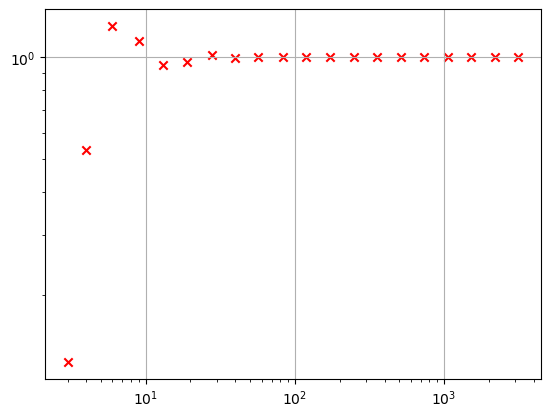

In [14]:
plt.scatter(nvals, errs, color="r", marker="x")
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.show()

## Driver Hamiltonian

Recall that $H_d = \sum_{j=0}^{n-2} Z_j Z_{j+1} + Z_{n-1}Z_0 + Y_0 Y_1$.

In [105]:
def get_driver(n):
    '''n: number of qubits'''
    # initialize
    Z = sp.csc_matrix([[1,0],[0,-1]])
    Y = sp.csc_matrix([[0, -1j],[1j, 0]])
    Hd = reduce(sp.kron, [Z, Z, sp.csc_matrix(sp.eye(2**(n-2)))])
    
    # loop over qubits
    for j in range(1, n-1):
        Hd += reduce(sp.kron, [sp.csc_matrix(sp.eye(2**j)),Z,Z,sp.csc_matrix(sp.eye(2**(n-j-2)))])
                
    # add final connections
    Hd += reduce(sp.kron, [Z,sp.csc_matrix(sp.eye(2**(n-2))),Z])
    Hd += reduce(sp.kron, [Y, Y, sp.csc_matrix(sp.eye(2**(n-2)))])
    return Hd.todense()

## Mixer Hamiltonian

Recall that $H_m = \sum_{j=0}^{n-1} X_j$.

In [89]:
def get_mixer(n):
    '''n: number of qubits'''
    X = sp.csc_matrix([[0,1],[1,0]])
    Hm = sp.kron(X, sp.csc_matrix(sp.eye(2**(n-1))))
    for j in range(1, n):
        Hm += reduce(sp.kron, [sp.csc_matrix(sp.eye(2**j)), X, sp.csc_matrix(sp.eye(2**(n-j-1)))])
    return Hm.todense()

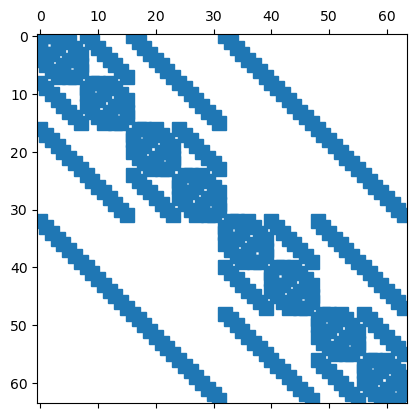

In [ ]:
plt.spy(get_mixer(6))

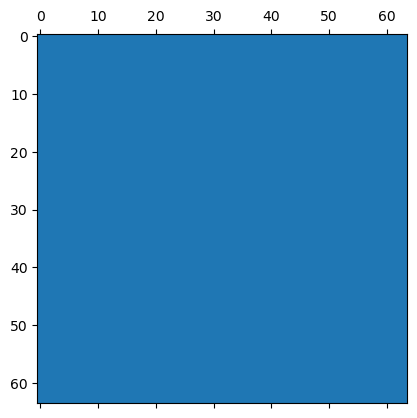

In [ ]:
plt.spy(spla.expm(get_mixer(6)*1j))

In [ ]:
2**np.arange(2,10)

array([  4,   8,  16,  32,  64, 128, 256, 512])

In [86]:
ns = np.arange(2,9)
sptimes = np.zeros(len(ns))
dentimes = np.zeros(len(ns))
for i, n in enumerate(ns):
    Hm = get_mixer(n)
    Hmd = Hm.todense()
    
    # time sparse expm
    start = time()
    spla.expm(Hm)
    sptimes[i] = time() - start
    
    # time dense expm
    start = time()
    expm(Hmd)
    dentimes[i] = time() - start

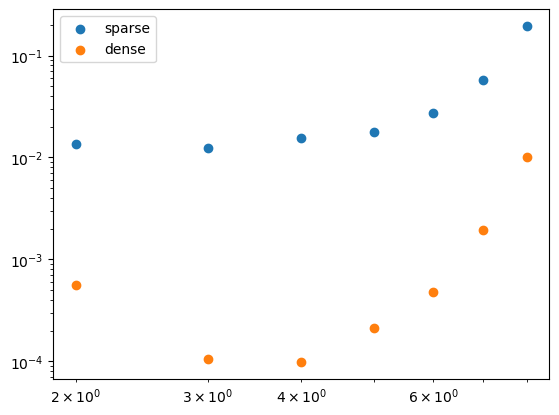

In [88]:
plt.scatter(ns, sptimes, label="sparse")
plt.scatter(ns, dentimes, label="dense")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="best")
plt.show()

Since the sparsity is not preserved in this case, the dense exponential is an order of magnitude faster.

# FQA Class

In [67]:
class FQA:
    
    def __init__(self, A, b, dt):
        # construct Hamiltonians
        self.Hp = self.get_problem(A, b)
        self.Hm = self.get_mixer()
        self.Hd = self.get_driver()
        self.get_eigs()
        
        # construct variables of interest
        self.dt = dt
        self.sol = eigh(self.Hp)[1][:,0]
        self.state = expm(-1j*5*self.Hm) @ eigh(self.Hd)[1][:,0]  # start in ground state of driver, evolved by mixer
        # self.state = expm(-1j*10*self.Hp) @ eigh(self.Hd)[1][:,0]  # start in ground state of driver, evolved by problem
        self.params = deque()
        self.overlaps = deque()
        self.objvals = deque()
        self.layer_count = 0
    
    
    def evolve(self, m):
        '''run the fqa for m layers'''
        for _ in tqdm(range(m)):
            self.one_layer()
    
    
    def rand_evolve(self, m, anim=False, fpath="figs/anim"):
        '''run the randomized fqa for m layers'''
        # simple code for no animation
        if not anim:
            for _ in tqdm(range(m)):
                self.one_rand_layer()
        
        # code to generate animation
        else:
            self.plot_curr_dist(fpath + "0.png")
            for i in tqdm(range(m)):
                self.one_rand_layer()
                self.plot_curr_dist(fpath + str(i+1) + ".png")
                
    
    def one_layer(self):
        '''evolve one layer of fqa'''
        self.params.append(self.get_param(self.Hd))
        # self.params.append(self.get_param(self.Hd) + 2*(np.random.rand() < 0.7)) # random kicks
        self.state = expm(-1j*self.dt*self.params[-1]*self.Hd) @ self.state
        self.params.append(self.get_param(self.Hm))
        # self.params.append(self.get_param(self.Hm) + 2*(np.random.rand() < 0.7)) # random kicks
        self.state = expm(-1j*self.dt*self.params[-1]*self.Hm) @ self.state
        self.state = expm(-1j*self.dt*self.Hp) @ self.state
        self.objvals.append(self.get_objval())
        self.overlaps.append(np.abs(np.dot(np.conjugate(self.sol), self.state))**2)
        self.layer_count += 1
    
    
    def one_rand_layer(self):
        '''evolve one layer of the randomized fqa'''
        Vk = random_clifford(self.n).to_matrix()
        curr_H = Vk @ self.Hd @ np.conjugate(Vk).T
        self.params.append(self.get_param(curr_H))
        self.state = expm(-1j*self.dt*self.params[-1]*curr_H) @ self.state
        self.objvals.append(self.get_objval())
        self.overlaps.append(np.abs(np.dot(np.conjugate(self.sol), self.state))**2)
        self.layer_count += 1
    
    
    def get_param(self, H):
        '''get parameter for Hamiltonian H with current state'''
        return -1j * np.dot(np.conjugate(self.state), (H @ self.Hp - self.Hp @ H) @ self.state)
    
    
    def get_objval(self):
        '''get value of objective function at current state'''
        return np.dot(np.conjugate(self.state), self.Hp @ self.state)
    
    
    def get_mixer(self):
        '''construct mixer Hamiltonian'''
        n = self.n
        X = sp.csc_matrix([[0,1],[1,0]])
        Hm = sp.kron(X, sp.csc_matrix(sp.eye(2**(n-1))))
        for j in range(1, n):
            Hm += reduce(sp.kron, [sp.csc_matrix(sp.eye(2**j)), X, sp.csc_matrix(sp.eye(2**(n-j-1)))])
        return np.array(Hm.todense())
    
    
    def get_driver(self):
        '''construct driver Hamiltonian'''
        n = self.n
        # initialize
        Z = sp.csc_matrix([[1,0],[0,-1]])
        Y = sp.csc_matrix([[0, -1j],[1j, 0]])
        Hd = reduce(sp.kron, [Z, Z, sp.csc_matrix(sp.eye(2**(n-2)))])

        # loop over qubits
        for j in range(1, n-1):
            Hd += reduce(sp.kron, [sp.csc_matrix(sp.eye(2**j)),Z,Z,sp.csc_matrix(sp.eye(2**(n-j-2)))])

        # add final connections
        Hd += reduce(sp.kron, [Z,sp.csc_matrix(sp.eye(2**(n-2))),Z])
        Hd += reduce(sp.kron, [Y, Y, sp.csc_matrix(sp.eye(2**(n-2)))])
        return np.array(Hd.todense())
    
    
    def get_problem(self, A, b):
        '''construct problem Hamiltonian'''
        self.n = int(np.log2(len(b)))
        return np.conjugate(A.T) @ (np.eye(2**self.n) - np.outer(b,b)) @ A
    
    
    def get_eigs(self):
        '''set eigenvalue info for Hp for plotting evolving histogram of probs'''
        self.evals, evecs = eigh(poisson3.Hp)
        self.eigmat = evecs.conjugate().T
        
    
    def plot_curr_dist(self, fpath=None):
        '''plot eigenstate probability distribution'''
        amps = self.eigmat @ poisson3.state
        probs = np.real(np.multiply(amps, amps.conjugate()))
        plt.bar(np.round(self.evals, decimals=2).astype(str), probs)
        plt.title(f"Layer: {self.layer_count}")
        if fpath is None:
            plt.show()
        else:
            plt.savefig(fpath)
            plt.clf()

# Testing Implementation

## Seven Qubit

In [7]:
N = 2**7
A = getA(N)
b = np.random.random(N)
b = b / np.linalg.norm(b)
poisson = FQA(A, b, 0.01)

In [12]:
eigh(poisson.Hp)[0]

array([1.36871017e-16, 5.61312535e-06, 2.59392304e-05, 8.96590965e-05,
       2.10376538e-04, 4.54174383e-04, 8.26658644e-04, 1.42807773e-03,
       2.26064560e-03, 3.47767723e-03, 4.97297440e-03, 7.17944233e-03,
       9.78354261e-03, 1.32436529e-02, 1.70362758e-02, 2.22514047e-02,
       2.84598750e-02, 3.57589574e-02, 4.40908679e-02, 5.40836840e-02,
       6.54832207e-02, 7.80424257e-02, 9.34004743e-02, 1.10218131e-01,
       1.28743116e-01, 1.50195725e-01, 1.73246561e-01, 1.99551199e-01,
       2.28811761e-01, 2.60080431e-01, 2.94982547e-01, 3.32353008e-01,
       3.73739140e-01, 4.19024972e-01, 4.67257764e-01, 5.18602771e-01,
       5.74080375e-01, 6.33827191e-01, 6.98488109e-01, 7.67619114e-01,
       8.35504764e-01, 9.17610274e-01, 9.99239883e-01, 1.08392925e+00,
       1.17744900e+00, 1.26448995e+00, 1.37065528e+00, 1.48053352e+00,
       1.58894461e+00, 1.70946841e+00, 1.83247678e+00, 1.96006511e+00,
       2.09330800e+00, 2.23164461e+00, 2.37591911e+00, 2.51058970e+00,
      

In [11]:
sum(eigh(poisson.Hp)[0] < 1e-1)

23

In [91]:
poisson.rand_evolve(3000)

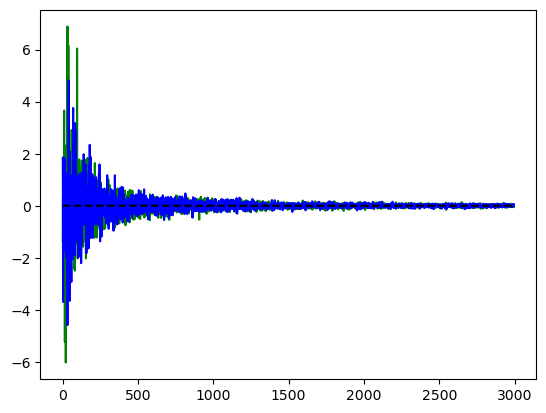

In [92]:
plt.plot(list(poisson.params)[::2], "g", label="driver")
plt.plot(list(poisson.params)[1::2], "b", label="mixer")
plt.plot(np.zeros(int(len(poisson.params)/2)), "k--")

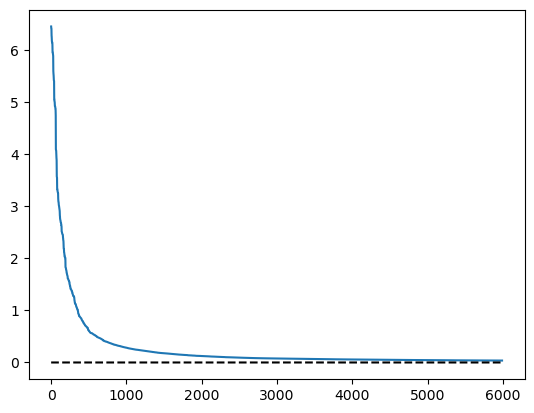

In [93]:
plt.plot(poisson.objvals)
plt.plot(np.zeros(len(poisson.objvals)), "k--")

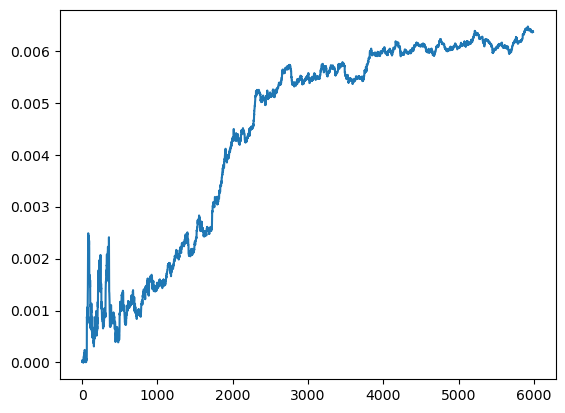

In [94]:
plt.plot(poisson.overlaps)

In [102]:
list(poisson.objvals)[-10:]

[(0.03709580705947795-8.517492267046123e-16j),
 (0.03707164124459754-4.666406150377611e-16j),
 (0.03707163009610465+9.8879238130678e-17j),
 (0.0370674505614336-7.979727989493313e-17j),
 (0.037057221907247896-2.6020852139652106e-16j),
 (0.03705587298994571-1.960237527853792e-16j),
 (0.037052462487899375-1.465841337200402e-16j),
 (0.037051981769492204-3.946495907847236e-16j),
 (0.03704246973555591-1.1275702593849246e-17j),
 (0.037027407152093225+3.443426099813962e-16j)]

In [129]:
poisson.rand_evolve(120000)

100%|███████████████████████████| 120000/120000 [2:56:39<00:00, 11.32it/s]


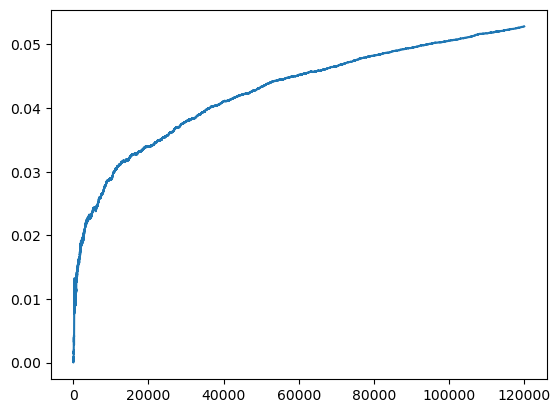

In [130]:
plt.plot(poisson.overlaps)

## Three Qubit

In [70]:
N = 2**3
A = getA(N)
b = np.random.random(N)
b = b / np.linalg.norm(b)
poisson3 = FQA(A, b, 0.02)

In [71]:
poisson3.rand_evolve(2000, anim=True, fpath="figs/poisson3rand_layer/frame")

100%|█████████████████████████████████| 2000/2000 [08:31<00:00,  3.91it/s]


<Figure size 640x480 with 0 Axes>

In [72]:
frames = [imageio.imread(f) for f in [f"figs/poisson3rand_layer/frame{i}.png" for i in range(2001)]]
imageio.mimwrite("figs/poisson3rand_layer.gif", frames)

/var/folders/bz/68lg1ys109jbpl3rbpx1jjmw0000gn/T/ipykernel_48608/3487453939.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(f) for f in [f"figs/poisson3rand_layer/frame{i}.png" for i in range(2001)]]


In [29]:
evals, evecs = eigh(poisson3.Hp)
eigmat = evecs.conjugate().T
amps = eigmat @ poisson3.state
probs = np.real(np.multiply(amps, amps.conjugate()))

In [33]:
evals

array([-2.64049300e-16,  2.03194072e-01,  8.91013924e-01,  2.65539170e+00,
        5.43506503e+00,  8.60751887e+00,  1.24107268e+01,  1.44210808e+01])

In [34]:
probs

array([5.10315486e-01, 4.61182088e-01, 2.83696790e-02, 9.98057689e-05,
       1.09433521e-05, 1.81520413e-05, 1.93074583e-06, 1.91589302e-06])

<BarContainer object of 8 artists>

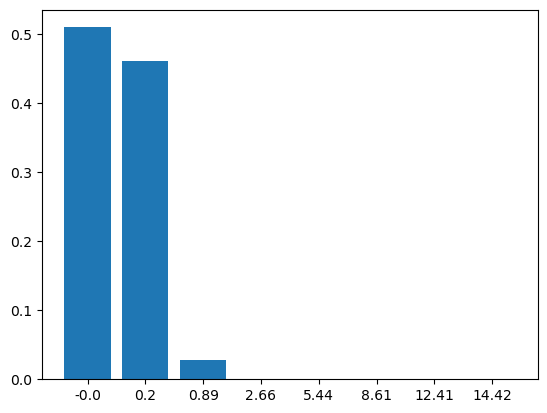

In [44]:
plt.bar(np.round(evals, decimals=2).astype(str), probs)

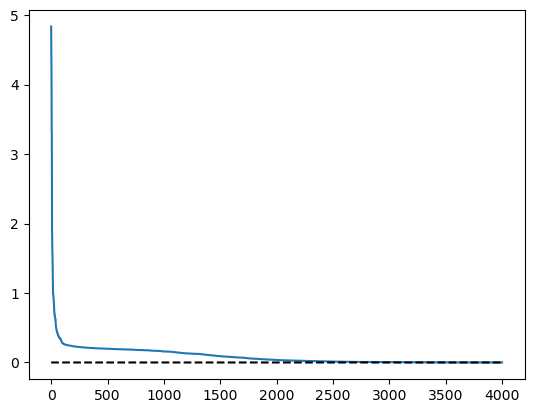

In [117]:
plt.plot(poisson3.objvals)
plt.plot(np.zeros(len(poisson3.objvals)), "k--")

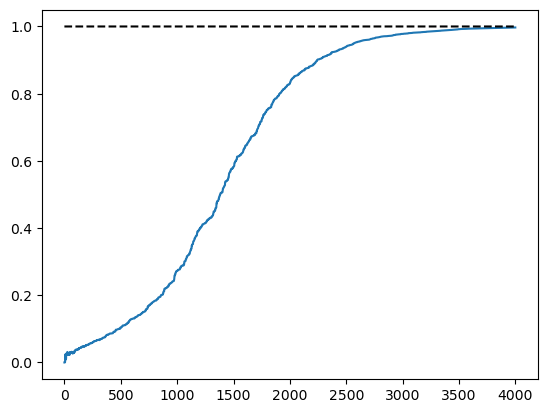

In [131]:
plt.plot(poisson3.overlaps)
plt.plot(np.ones(len(poisson3.overlaps)), "k--")

In [119]:
poisson3.overlaps[-1]

0.9969799378262445

100%|███████████████████████████████| 4000/4000 [00:01<00:00, 2276.74it/s]


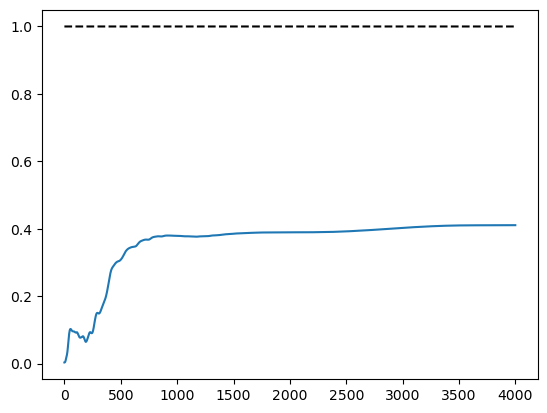

In [133]:
N = 2**3
A = getA(N)
b = np.random.random(N)
b = b / np.linalg.norm(b)
poisson3d = FQA(A, b, 0.01)
poisson3d.evolve(4000)
plt.plot(poisson3d.overlaps)
plt.plot(np.ones(len(poisson3d.overlaps)), "k--")

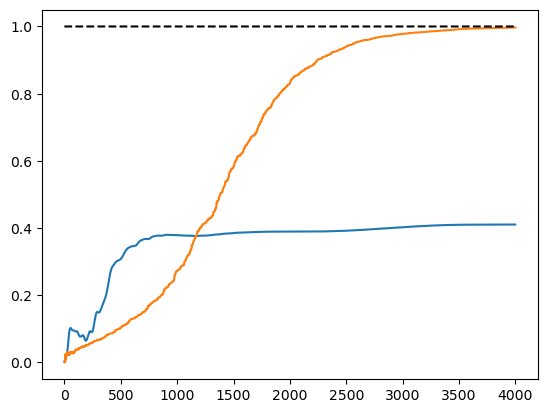

In [134]:
plt.plot(poisson3d.overlaps)
plt.plot(poisson3.overlaps)
plt.plot(np.ones(len(poisson3d.overlaps)), "k--")

In [146]:
N = 2**3
A = getA(N)
b = np.random.random(N)
b = b / np.linalg.norm(b)
poisson3dr = FQA(A, b, 0.01)
poisson3dr.evolve(500)

100%|██████████████████████████████████| 500/500 [00:00<00:00, 617.68it/s]


In [149]:
poisson3dr.rand_evolve(500)
poisson3dr.evolve(500)

100%|██████████████████████████████████| 500/500 [00:00<00:00, 817.45it/s]


In [151]:
poisson3dr.evolve(500)

100%|██████████████████████████████████| 500/500 [00:04<00:00, 110.47it/s]


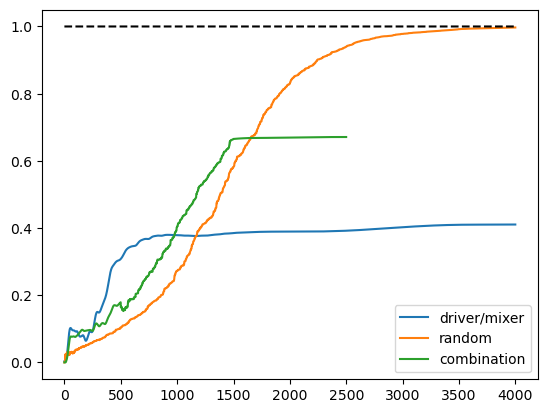

In [152]:
plt.plot(poisson3d.overlaps, label="driver/mixer")
plt.plot(poisson3.overlaps, label="random")
plt.plot(poisson3dr.overlaps, label="combination")
plt.plot(np.ones(len(poisson3d.overlaps)), "k--")
plt.legend(loc="best")